# **Ubicomp SOAR tutorial**



Please **save a copy of this Colab notebook into your Drive** before you start working.

This can be done by clicking on *File > Save a Copy in Drive*.


In [1]:
%load_ext autoreload
%autoreload 2

## Google Drive Mounting

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Directories

In [3]:
import os
import sys

# base_directory = "/content/soar/" # Uncomment this if you wish not to use Google Drive
base_directory = "/content/gdrive/MyDrive/ubicomp2023_soar/"
repo = os.path.join(base_directory, "soar_tutorial")
data_directory = os.path.join(repo, "data")
# sys.path.append(repo)

In [4]:
%%capture
!pip install numpy scipy scikit-learn seaborn matplotlib pandas lightly

In [5]:
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import random
import glob
from datetime import date
import itertools
import pickle

# progress bar
from tqdm.auto import tqdm

# Various metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Setting seeds
np.random.seed(42)
random.seed(42)

In [6]:
os.makedirs(base_directory, exist_ok=True)
%cd $base_directory

/content/gdrive/MyDrive/ubicomp2023_soar


In [7]:
def plot_accelerometer_timeseries(timeseries, title="", figsize=(15,6), xlim=None, ylim=None):
    plt.figure(figsize=figsize)
    if len(timeseries.shape) == 1:
        plt.plot(timeseries)
    else:
        for i in range(3):
            plt.plot(timeseries[:, i], label=["x","y","z"][i])
    if xlim is None:
        plt.xlim(0, len(timeseries))
    else:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()

label_mapping = {
    0: "lying",
    1: "sitting",
    2: "standing",
    3: "walking",
    4: "running",
    5: "cycling",
    6: "Nordic walking",
    7: "ascending stairs",
    8: "descending stairs",
    9: "vacuum cleaning",
    10: "ironing",
    11: "rope jumping",
}
num_ticks = 12
cm_ticks = np.linspace(0, num_ticks-1, num_ticks, dtype=int)
cm_ticklabels = [label_mapping[idx] for idx in cm_ticks]


## **Cloning the existing repository with the code**




In [8]:
!if cd $repo; then git pull; else git clone https:://github.com/ubicompsoartutorial/soar_tutorial.git; fi
%cd $repo

Already up to date.
/content/gdrive/MyDrive/ubicomp2023_soar/soar_tutorial


# 0 Data Preparation

## 0.1 **Downloading the PAMAP2 data**

In [9]:
if os.path.exists(os.path.join(data_directory, "pamap2+physical+activity+monitoring.zip")):
    print("Dataset already downloaded")
else:
    !wget https://archive.ics.uci.edu/static/public/231/pamap2+physical+activity+monitoring.zip -P $data_directory

Dataset already downloaded


In [10]:
%%capture
%cd $data_directory
if not os.path.exists(os.path.join(data_directory, "PAMAP2_Dataset.zip")):
    !unzip pamap2+physical+activity+monitoring.zip
if not os.path.exists(os.path.join(data_directory, "PAMAP2_Dataset/readme.pdf")):
    !unzip PAMAP2_Dataset.zip


## 0.2 Data pre-processing

In [11]:
%cd $repo
import data_preparation.prepare_pamap2 as prepare

# Loading the arguments first
args = prepare.load_args()
print(args)

# Obtaining the processed data
processed = prepare.prepare_data(args)

/content/gdrive/MyDrive/ubicomp2023_soar/soar_tutorial
Parameters for preparing PAMAP2 -- wrist
{'dataset_loc': 'data/PAMAP2_Dataset', 'original_sampling_rate': 100, 'sampling_rate': 50}


  0%|          | 0/14 [00:00<?, ?it/s]

Subject 1	 data shape: (188209, 54)
Subject 2	 data shape: (223500, 54)
Subject 3	 data shape: (126417, 54)
Subject 4	 data shape: (164788, 54)
Subject 5	 data shape: (187392, 54)
Subject 6	 data shape: (180909, 54)
Subject 7	 data shape: (156800, 54)
Subject 8	 data shape: (204016, 54)
Subject 9	 data shape: (4239, 54)
Subject 1	 data shape: (159676, 54)
Subject 5	 data shape: (77387, 54)
Subject 6	 data shape: (64982, 54)
Subject 8	 data shape: (90206, 54)
Subject 9	 data shape: (96736, 54)
All subjects 	 data shape: (1925257, 5)
After removal 	 data shape: (971436, 5)

Activity mapping:
Encoded label - activity
11 - rope jumping
0 - lying
1 - sitting
2 - standing
3 - walking
4 - running
5 - cycling
6 - Nordic walking
7 - ascending stairs
8 - descending stairs
9 - vacuum cleaning
10 - ironing

The unique subjects are: [1. 2. 3. 4. 5. 6. 7. 8. 9.]
The train and validation subjects are: [6. 1. 9. 3. 5. 4. 7.]
The test subjects are: [8. 2.]
{'train': array([4., 9., 5., 3., 7.]), 'val': 

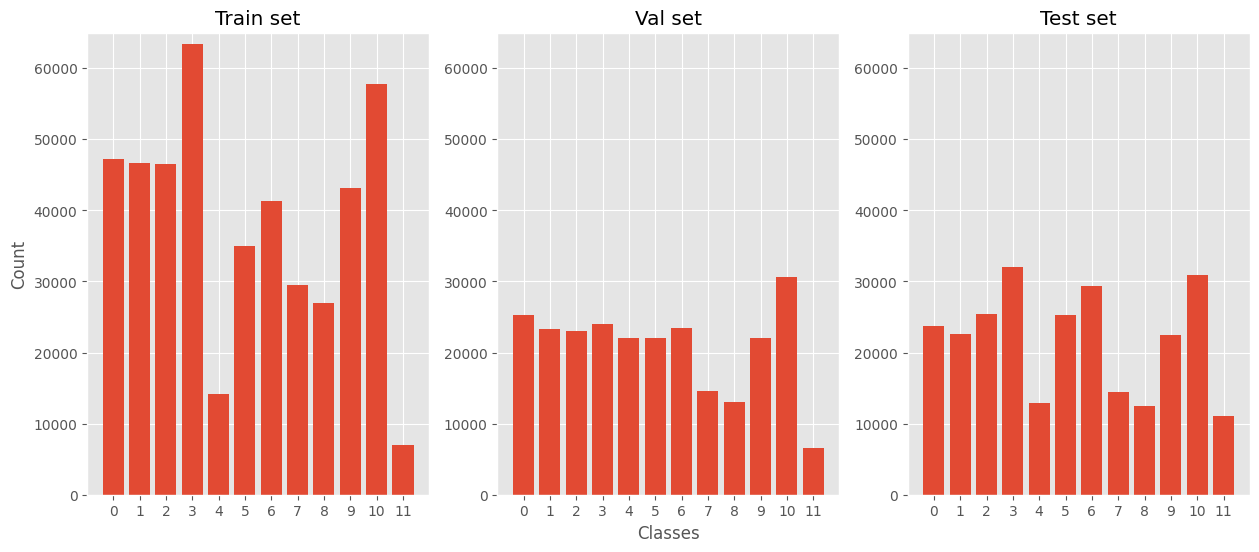

In [12]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
for i, split, title in zip(range(3), ['train', 'val', 'test'], ["Train", "Val", "Test"]):
    labels, counts = np.unique(processed[split]['labels'], return_counts=True)
    axs[i].bar(labels, counts)
    axs[i].set_title(title + " set")
    axs[i].set_xticks(range(12), range(12))
    axs[i].set_ylim([0, 65000])
axs[0].set_ylabel("Count")
axs[1].set_xlabel("Classes")
# plt.ylim([0, 65000])
plt.show()

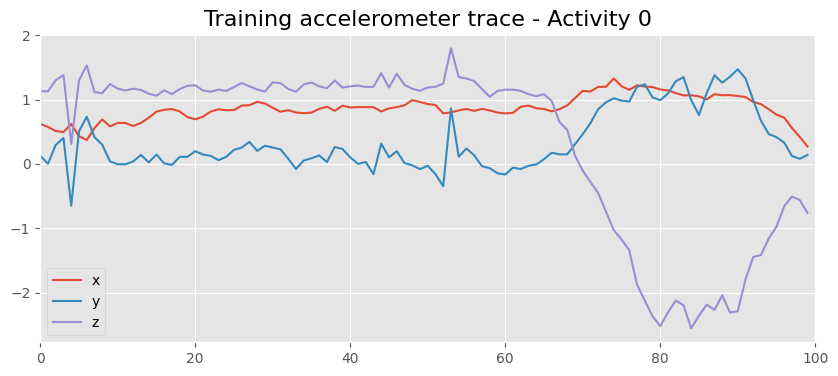

In [13]:
plot_accelerometer_timeseries(processed['train']['data'][:100], f"Training accelerometer trace - Activity {processed['train']['labels'][100]}", figsize=(10,4))


# 1 Activity Recognition Chain

## 1.0 **Segmentation: obtaining windows of sensor data through sliding window**

### Goal: take stream of sensor data and return windows + labels


In [14]:
processed_data_files = glob.glob(os.path.join(repo, "data_preparation", "all_data", "*", "pamap2.pkl"))
processed_data_files.sort(key=os.path.getmtime)
processed_data_file = processed_data_files[-1]
processed = pd.read_pickle(processed_data_file)
processed_data_file

'/content/gdrive/MyDrive/ubicomp2023_soar/soar_tutorial/data_preparation/all_data/Dec-15-2023/pamap2.pkl'

In [15]:
import ecdf.extract_ecdf_train_classifier as ecdf

# Obtaining the segmented data
segmented_data = ecdf.generate_windowed_data(processed=processed)

(18346, 50, 3) (18346,)
(10000, 50, 3) (10000,)
(10508, 50, 3) (10508,)


### Before Segmentation

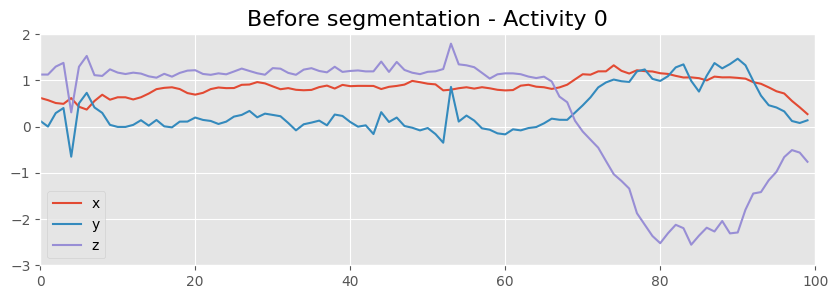

In [16]:
plot_accelerometer_timeseries(processed['train']['data'][:100], f"Before segmentation - Activity {processed['train']['labels'][100]}", ylim=(-3,2), figsize=(10,3))

### After Segmentation

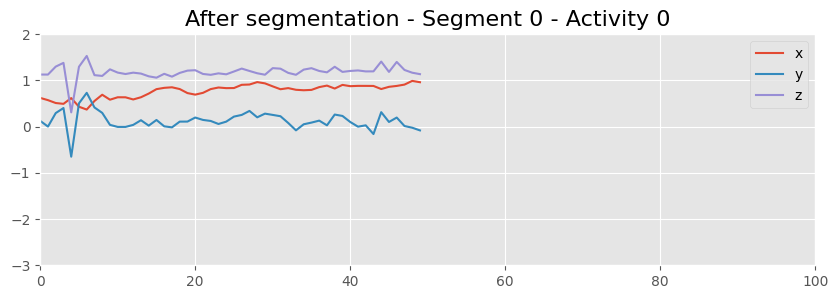

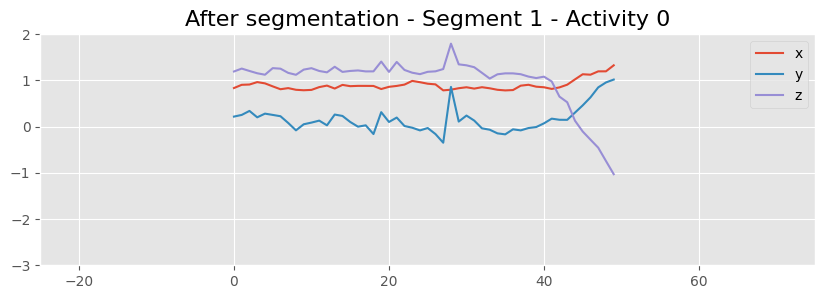

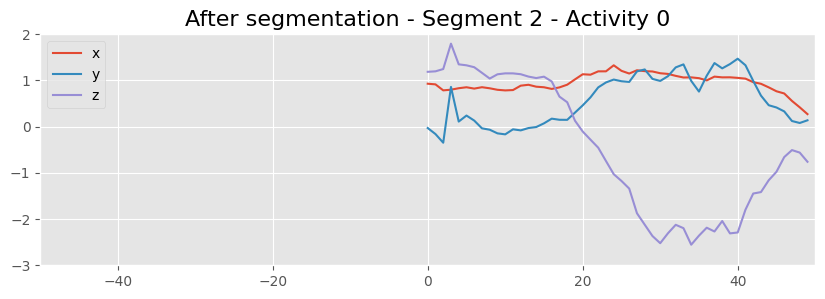

In [17]:
for i in range(3):
    plot_accelerometer_timeseries(segmented_data['train']['data'][i], f"After segmentation - Segment {i} - Activity {segmented_data['train']['labels'][i]}", xlim=(-i*25, 100-i*25), ylim=(-3,2), figsize=(10,3))

## 1.1 **Extracting features: ECDF**

In [18]:
# Computing the ECDF features
ecdf_features = ecdf.compute_ecdf_features(segmented_data=segmented_data)

  0%|          | 0/3 [00:00<?, ?it/s]

train (18346, 78)
val (10000, 78)
test (10508, 78)


## 1.2 **Training a Random Forest classifier with ECDF features for Activity Recognition**

In [19]:
# Training the RF classifier
trained_classifier, log_ecdf = ecdf.train_rf_classifier(ecdf=ecdf_features, segmented_data=segmented_data)

Phase: train, mean F1-score: 1.0
Phase: val, mean F1-score: 0.49662843655851546
Phase: test, mean F1-score: 0.41590719748554394


In [20]:
confusion_matrix_ecdf = confusion_matrix(segmented_data["test"]["labels"], trained_classifier.predict(ecdf_features["test"]))
confusion_matrix_ecdf_norm = confusion_matrix_ecdf / np.sum(confusion_matrix_ecdf, axis=1, keepdims=True)
os.makedirs(os.path.join(repo, "ecdf", "saved_logs", "current"), exist_ok=True)
with open(os.path.join(repo, "ecdf", "saved_logs", "current", "ecdf_eval_log.pkl"), 'wb') as f:
  pickle.dump(
      {"cm": confusion_matrix_ecdf_norm,
       "f1": log_ecdf
      },
  f)

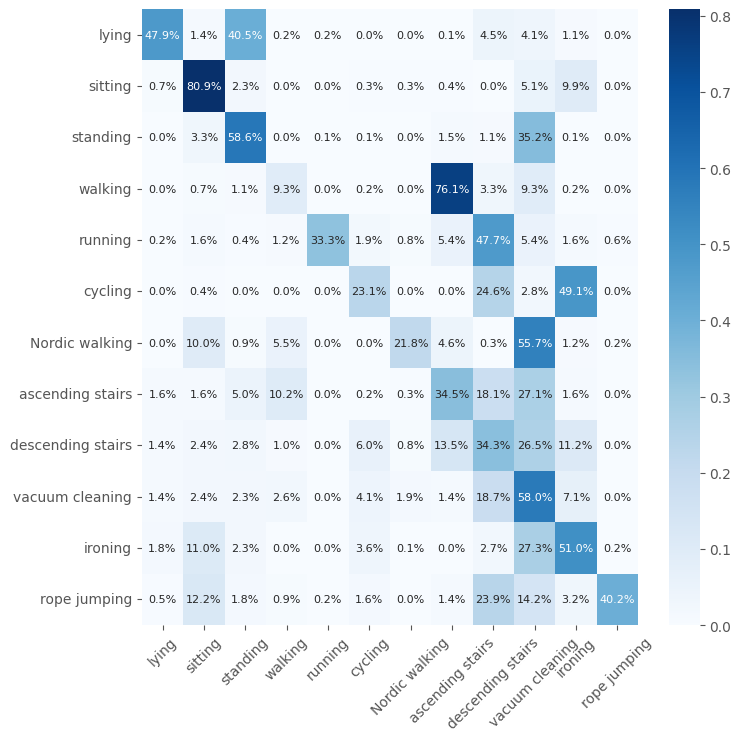

In [21]:
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix_ecdf_norm, annot=True, fmt='.1%', cmap='Blues', annot_kws={"fontsize":8}, yticklabels=cm_ticklabels, xticklabels=cm_ticklabels)
plt.xticks(rotation=45)
plt.show()

## Tsfresh

In [22]:
!pip install tsfresh

In [23]:
from tsfresh import extract_features as tsf
from tsfresh import extract_features
from copy import deepcopy

In [24]:
segmented_1 = deepcopy(segmented_data)

In [25]:
segmented_1['train']['data'].shape

(18346, 50, 3)

In [26]:
for phase in ['train', 'val', 'test']:

  segmented_1[phase]['data'] = np.reshape(segmented_1[phase]['data'],
  (segmented_1[phase]['data'].shape[0],
    segmented_1[phase]['data'].shape[1]*segmented_1[phase]['data'].shape[2])
  )
  print(segmented_1[phase]['data'].shape)

(18346, 150)
(10000, 150)
(10508, 150)


In [27]:
id = np.repeat(np.arange(len(segmented_1['train']['data'])), segmented_1['train']['data'].shape[1])
id

array([    0,     0,     0, ..., 18345, 18345, 18345])

In [28]:
id_val =  np.repeat(np.arange(len(segmented_1['val']['data'])), segmented_1['val']['data'].shape[1])
id_val

array([   0,    0,    0, ..., 9999, 9999, 9999])

In [29]:
id_test =  np.repeat(np.arange(len(segmented_1['test']['data'])), segmented_1['test']['data'].shape[1])
id_test

array([    0,     0,     0, ..., 10507, 10507, 10507])

In [30]:
segmented_1['train']['labels']

array([ 0,  0,  0, ..., 11, 11, 11], dtype=uint8)

In [31]:
len(segmented_1['train']['data'])*150

2751900

In [32]:
len(segmented_1['train']['data'][0])

150

In [33]:
train_dict = {
    'id': id,
    'value': segmented_1['train']['data'].ravel()
}

train_df = pd.DataFrame(train_dict)
train_df.head()

,id,value
0,0,0.622810
1,0,0.125303
2,0,1.128552
3,0,0.574242
4,0,0.002336


In [34]:
len(train_df)

2751900

In [35]:
import numpy as np

# Assuming you have an array named 'arr'
arr = np.array([1, 2, 3, 4])

# Repeat each element 4 times
result = np.repeat(arr, 4)

# Print or use the resulting array
print(result)


[1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]


In [36]:
label_repeat = np.array(segmented_1['train']['labels'])
label_repeat = np.repeat(label_repeat, len(segmented_1['train']['data'][0]))

label_dict = {
    'label': label_repeat,
}

train_label = pd.DataFrame(label_dict)
train_label.head()

,label
0,0
1,0
2,0
3,0
4,0


In [37]:
label_repeat = np.array(segmented_1['val']['labels'])
label_repeat = np.repeat(label_repeat, len(segmented_1['val']['data'][0]))

label_dict = {
    'label': label_repeat,
}

val_label = pd.DataFrame(label_dict)

In [38]:
label_repeat = np.array(segmented_1['test']['labels'])
label_repeat = np.repeat(label_repeat, len(segmented_1['test']['data'][0]))

label_dict = {
    'label': label_repeat,
}

test_label = pd.DataFrame(label_dict)
test_label.head()

,label
0,0
1,0
2,0
3,0
4,0


In [39]:
val_dict = {
    'id': id_val,
    'value': segmented_1['val']['data'].ravel()
}

val_df = pd.DataFrame(val_dict)
val_df.head()

,id,value
0,0,1.306951
1,0,0.724978
2,0,0.472943
3,0,1.320598
4,0,0.507559


In [40]:
test_dict = {
    'id': id_test,
    'value': segmented_1['test']['data'].ravel()
}

test_df = pd.DataFrame(test_dict)
test_df.head()

,id,value
0,0,-0.335228
1,0,0.392848
2,0,-0.260650
3,0,-0.350898
4,0,0.377934


In [41]:
mini_test = test_df.head(5000)
mini_val = val_df.head(5000)
mini_train = train_df.head(5000)

In [42]:
print(len(train_df))

2751900


In [43]:
print(len(train_label))

2751900


In [44]:
n = 1000

random_indices = np.random.choice(val_df.index, size=n, replace=False)

mini_val = val_df.loc[random_indices]
mini_val_label = val_label.loc[random_indices]

In [45]:
n = 1000

random_indices = np.random.choice(val_df.index, size=n, replace=False)

mini_test = test_df.loc[random_indices]
mini_test_label = test_label.loc[random_indices]

In [46]:
from ssl import OP_NO_COMPRESSION
n = 10000 # change n to be size of subset of  training data

random_indices = np.random.choice(train_df.index, size=n, replace=False)

mini_train = train_df.loc[random_indices]
mini_label = train_label.loc[random_indices]

In [47]:
mini_train.head()

,id,value
2579421,17196,0.445071
2669298,17795,0.329392
1084549,7230,-0.439157
649425,4329,0.467953
2471992,16479,0.035824


In [48]:
mini_label.head()

,label
2579421,6
2669298,5
1084549,6
649425,1
2471992,3


Just an example for you to see, ignore it as it does not make a difference

In [49]:
test = pd.DataFrame(
    {
        'value': [1, 2, 3, 4],
        'id': [0, 0, 1, 1]
    }
)
test

,value,id
0,1,0
1,2,0
2,3,1
3,4,1


In [50]:
extracted_features = extract_features(test, column_id="id")
extracted_features.shape

Feature Extraction: 100%|██████████| 2/2 [00:00<00:00, 31.39it/s]


(2, 783)

The code continues here

In [51]:
mini_train['RowNumber'] = mini_train.reset_index().index

In [52]:
extracted_features = extract_features(mini_train, column_id="RowNumber")
extracted_features

Feature Extraction: 100%|██████████| 20000/20000 [10:14<00:00, 32.54it/s]


,id__variance_larger_than_standard_deviation,id__has_duplicate_max,id__has_duplicate_min,id__has_duplicate,id__sum_values,id__abs_energy,id__mean_abs_change,id__mean_change,id__mean_second_derivative_central,id__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,17196.0,295702416.0,NaN,NaN,NaN,17196.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,17795.0,316662025.0,NaN,NaN,NaN,17795.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,7230.0,52272900.0,NaN,NaN,NaN,7230.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,4329.0,18740241.0,NaN,NaN,NaN,4329.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,16479.0,271557441.0,NaN,NaN,NaN,16479.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,16292.0,265429264.0,NaN,NaN,NaN,16292.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,0.0,0.0,0.0,0.0,11416.0,130325056.0,NaN,NaN,NaN,11416.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,0.0,0.0,0.0,0.0,952.0,906304.0,NaN,NaN,NaN,952.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,0.0,0.0,0.0,0.0,7857.0,61732449.0,NaN,NaN,NaN,7857.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
print(extracted_features.columns)

Index(['id__variance_larger_than_standard_deviation', 'id__has_duplicate_max',
       'id__has_duplicate_min', 'id__has_duplicate', 'id__sum_values',
       'id__abs_energy', 'id__mean_abs_change', 'id__mean_change',
       'id__mean_second_derivative_central', 'id__median',
       ...
       'value__fourier_entropy__bins_5', 'value__fourier_entropy__bins_10',
       'value__fourier_entropy__bins_100',
       'value__permutation_entropy__dimension_3__tau_1',
       'value__permutation_entropy__dimension_4__tau_1',
       'value__permutation_entropy__dimension_5__tau_1',
       'value__permutation_entropy__dimension_6__tau_1',
       'value__permutation_entropy__dimension_7__tau_1',
       'value__query_similarity_count__query_None__threshold_0.0',
       'value__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=1566)


In [54]:
features_to_extract = extracted_features.columns

In [55]:
mini_train.iloc[90]

id           12818.000000
value            0.358513
RowNumber       90.000000
Name: 1922795, dtype: float64

In [56]:
print(mini_train.shape)
print(extracted_features.shape)

(10000, 3)
(10000, 1566)


In [57]:
print(mini_train.columns.tolist())
print(mini_train.head())

['id', 'value', 'RowNumber']
            id     value  RowNumber
2579421  17196  0.445071          0
2669298  17795  0.329392          1
1084549   7230 -0.439157          2
649425    4329  0.467953          3
2471992  16479  0.035824          4


In [58]:
mini_test['RowNumber'] = mini_test.reset_index().index

In [59]:
extracted_features_test = extract_features(mini_test, column_id="RowNumber")
extracted_features_test

Feature Extraction: 100%|██████████| 2000/2000 [01:01<00:00, 32.47it/s]


,id__variance_larger_than_standard_deviation,id__has_duplicate_max,id__has_duplicate_min,id__has_duplicate,id__sum_values,id__abs_energy,id__mean_abs_change,id__mean_change,id__mean_second_derivative_central,id__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,7231.0,52287361.0,NaN,NaN,NaN,7231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,8004.0,64064016.0,NaN,NaN,NaN,8004.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,7237.0,52374169.0,NaN,NaN,NaN,7237.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,4334.0,18783556.0,NaN,NaN,NaN,4334.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,6517.0,42471289.0,NaN,NaN,NaN,6517.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,1830.0,3348900.0,NaN,NaN,NaN,1830.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,0.0,0.0,0.0,0.0,9083.0,82500889.0,NaN,NaN,NaN,9083.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,0.0,0.0,0.0,0.0,9154.0,83795716.0,NaN,NaN,NaN,9154.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,0.0,0.0,0.0,0.0,9302.0,86527204.0,NaN,NaN,NaN,9302.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
mini_val['RowNumber'] = mini_val.reset_index().index

In [61]:
extracted_features_val = extract_features(mini_val, column_id="RowNumber")
extracted_features_val

Feature Extraction: 100%|██████████| 2000/2000 [01:02<00:00, 31.94it/s]


,id__variance_larger_than_standard_deviation,id__has_duplicate_max,id__has_duplicate_min,id__has_duplicate,id__sum_values,id__abs_energy,id__mean_abs_change,id__mean_change,id__mean_second_derivative_central,id__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,3961.0,15689521.0,NaN,NaN,NaN,3961.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,7265.0,52780225.0,NaN,NaN,NaN,7265.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,2176.0,4734976.0,NaN,NaN,NaN,2176.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,1024.0,1048576.0,NaN,NaN,NaN,1024.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,9438.0,89075844.0,NaN,NaN,NaN,9438.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,6424.0,41267776.0,NaN,NaN,NaN,6424.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,0.0,0.0,0.0,0.0,941.0,885481.0,NaN,NaN,NaN,941.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,0.0,0.0,0.0,0.0,8939.0,79905721.0,NaN,NaN,NaN,8939.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,0.0,0.0,0.0,0.0,9725.0,94575625.0,NaN,NaN,NaN,9725.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## End of feature extraction! Continue with the commands from the docs here.

In [62]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)
impute(extracted_features_test)
impute(extracted_features_val)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['id__mean_abs_change' 'id__mean_change'
 'id__mean_second_derivative_central' ...
 'value__permutation_entropy__dimension_7__tau_1'
 'value__query_similarity_count__query_None__threshold_0.0'
 'value__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['id__mean_abs_change' 'id__mean_change'
 'id__mean_second_derivative_central' ...
 'value__permutation_entropy__dimension_7__tau_1'
 'value__query_similarity_count__query_None__threshold_0.0'
 'value__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['id__mean_abs_change' 'id__mean

,id__variance_larger_than_standard_deviation,id__has_duplicate_max,id__has_duplicate_min,id__has_duplicate,id__sum_values,id__abs_energy,id__mean_abs_change,id__mean_change,id__mean_second_derivative_central,id__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,3961.0,15689521.0,0.0,0.0,0.0,3961.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,7265.0,52780225.0,0.0,0.0,0.0,7265.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,2176.0,4734976.0,0.0,0.0,0.0,2176.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1024.0,1048576.0,0.0,0.0,0.0,1024.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,9438.0,89075844.0,0.0,0.0,0.0,9438.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,6424.0,41267776.0,0.0,0.0,0.0,6424.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,941.0,885481.0,0.0,0.0,0.0,941.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,8939.0,79905721.0,0.0,0.0,0.0,8939.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,9725.0,94575625.0,0.0,0.0,0.0,9725.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
#print(train_label.head)
mini_y = mini_label["label"].reset_index(drop=False)
features_filtered = select_features(extracted_features, mini_y['label'])

In [64]:
mini_test_y = mini_test_label["label"].reset_index(drop=False)
test_features_filtered = select_features(extracted_features_test, mini_test_y['label'])

In [65]:
mini_val_y = mini_val_label["label"].reset_index(drop=False)
val_features_filtered = select_features(extracted_features_val, mini_val_y['label'])

In [66]:
extracted_features

,id__variance_larger_than_standard_deviation,id__has_duplicate_max,id__has_duplicate_min,id__has_duplicate,id__sum_values,id__abs_energy,id__mean_abs_change,id__mean_change,id__mean_second_derivative_central,id__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,17196.0,295702416.0,0.0,0.0,0.0,17196.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,17795.0,316662025.0,0.0,0.0,0.0,17795.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,7230.0,52272900.0,0.0,0.0,0.0,7230.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4329.0,18740241.0,0.0,0.0,0.0,4329.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,16479.0,271557441.0,0.0,0.0,0.0,16479.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,16292.0,265429264.0,0.0,0.0,0.0,16292.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,11416.0,130325056.0,0.0,0.0,0.0,11416.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,952.0,906304.0,0.0,0.0,0.0,952.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,7857.0,61732449.0,0.0,0.0,0.0,7857.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
features_filtered

,value__count_below__t_0,value__range_count__max_1000000000000.0__min_0,value__range_count__max_0__min_-1000000000000.0,"value__fft_coefficient__attr_""angle""__coeff_0",value__count_above__t_0,id__benford_correlation,"id__fft_coefficient__attr_""abs""__coeff_0","id__fft_coefficient__attr_""real""__coeff_0","id__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","id__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)",...,value__mean,value__sum_values,value__quantile__q_0.6,value__median,value__range_count__max_1__min_-1,value__absolute_maximum,value__root_mean_square,"value__fft_coefficient__attr_""abs""__coeff_0",value__abs_energy,value__benford_correlation
0,0.0,1.0,0.0,0.0,1.0,0.864123,17196.0,17196.0,3334.988485,4716.385946,...,0.445071,0.445071,0.445071,0.445071,1.0,0.445071,0.445071,0.445071,0.198089,-0.064614
1,0.0,1.0,0.0,0.0,1.0,0.864123,17795.0,17795.0,3451.158414,4880.675035,...,0.329392,0.329392,0.329392,0.329392,1.0,0.329392,0.329392,0.329392,0.108499,0.062915
2,1.0,0.0,1.0,180.0,0.0,-0.241690,7230.0,7230.0,1402.184621,1982.988508,...,-0.439157,-0.439157,-0.439157,-0.439157,1.0,0.439157,0.439157,0.439157,0.192858,-0.064614
3,0.0,1.0,0.0,0.0,1.0,-0.064614,4329.0,4329.0,839.565315,1187.324655,...,0.467953,0.467953,0.467953,0.467953,1.0,0.467953,0.467953,0.467953,0.218980,-0.064614
4,0.0,1.0,0.0,0.0,1.0,0.864123,16479.0,16479.0,3195.933662,4519.732729,...,0.035824,0.035824,0.035824,0.035824,1.0,0.035824,0.035824,0.035824,0.001283,0.062915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,1.0,180.0,0.0,0.864123,16292.0,16292.0,3159.666923,4468.443814,...,-0.434345,-0.434345,-0.434345,-0.434345,1.0,0.434345,0.434345,0.434345,0.188655,-0.064614
9996,1.0,0.0,1.0,180.0,0.0,0.864123,11416.0,11416.0,2214.016547,3131.092228,...,-0.560496,-0.560496,-0.560496,-0.560496,1.0,0.560496,0.560496,0.560496,0.314156,-0.145280
9997,0.0,1.0,0.0,0.0,1.0,-0.297356,952.0,952.0,184.630672,261.107201,...,1.666337,1.666337,1.666337,1.666337,0.0,1.666337,1.666337,1.666337,2.776679,0.864123
9998,1.0,0.0,1.0,180.0,0.0,-0.241690,7857.0,7857.0,1523.784864,2154.957221,...,-1.543633,-1.543633,-1.543633,-1.543633,0.0,1.543633,1.543633,1.543633,2.382803,0.864123


In [68]:
print(len(features_filtered.columns))
print(len(extracted_features.columns))
print(len(extracted_features_val.columns))
print(len(extracted_features_test.columns))

52
1566
1566
1566


In [69]:
len(filtered_columns)

NameError: ignored

In [ ]:
filtered_columns = features_filtered.columns

In [ ]:
print(mini_test_y.columns)

In [ ]:
test_features_filtered

In [ ]:
val_features_filtered

In [ ]:
features_filtered.columns

In [ ]:
columns = [
    'value__count_below__t_0',
    'value__range_count__max_1000000000000.0__min_0',
    'value__range_count__max_0__min_-1000000000000.0',
    'value__fft_coefficient__attr_"angle"__coeff_0',
    'value__count_above__t_0',
    'id__benford_correlation',
    'value__mean',
    'value__maximum',
    'value__minimum',
    'value__quantile__q_0.1',
    'value__quantile__q_0.2',
    'value__quantile__q_0.3',
    'value__quantile__q_0.4',
    'value__quantile__q_0.8',
    'value__quantile__q_0.7',
    'value__quantile__q_0.9',
    'value__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
    'value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
    'value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
    'value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
    'value__fft_coefficient__attr_"real"__coeff_0',
    'value__quantile__q_0.6',
    'value__sum_values',
    'value__median',
    'id__quantile__q_0.4',
    'id__abs_energy',
    'id__median',
    'id__mean',
    'id__root_mean_square',
    'id__maximum',
    'id__absolute_maximum',
    'id__minimum',
    'id__quantile__q_0.1',
    'id__quantile__q_0.2',
    'id__quantile__q_0.3',
    'id__fft_coefficient__attr_"abs"__coeff_0',
    'id__sum_values',
    'id__quantile__q_0.7',
    'id__quantile__q_0.8',
    'id__quantile__q_0.9',
    'id__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
    'id__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
    'id__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
    'id__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
    'id__fft_coefficient__attr_"real"__coeff_0',
    'id__quantile__q_0.6',
    'value__benford_correlation'
]

# Concatenate the columns into a single line of text
text_line = ', '.join(columns)

# Print or use the result
print(text_line)


In [ ]:
print(features_filtered.shape)
print(mini_y.shape)

In [ ]:
#filtered_columns
#extracted_features_test
#extracted_features_val
features_filtered_test = extracted_features_test[filtered_columns]
features_filtered_val = extracted_features_val[filtered_columns]

In [ ]:
len(features_filtered_test.columns)
len(features_filtered_val.columns)

In [ ]:
tsfresh_dict = {
    'Train_Selected_Features': features_filtered,
    'Train_Labels': mini_y,
    'Test_Data': test_features_filtered,
    'Test_Labels': mini_test_y,
    'Val_Data': val_features_filtered,
    'Val_Labels': mini_val_y,
}

In [ ]:
import pandas as pd
import pickle
from google.colab import files

# Assuming you have a dictionary of DataFrames named df_dict
# df_dict = {'DataFrame1': df1, 'DataFrame2': df2, ...}

# Serialize the dictionary using pickle
pickle_filename = 'downloaded_data.pkl'
with open(pickle_filename, 'wb') as pickle_file:
    pickle.dump(tsfresh_dict, pickle_file)

# Download the pickle file
files.download(pickle_filename)


In [ ]:
import pickle

# Replace 'your_data.pkl' with the actual filename or path
file_path = 'downloaded_data.pkl'

# Load the data from the pickle file
with open(file_path, 'rb') as file:
    loaded_data = pickle.load(file)

# Now 'loaded_data' contains the data from the pickle file


In [ ]:
loaded_data.keys()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score

#discretizer = KBinsDiscretizer(n_bins=25, encode='ordinal', strategy='uniform')
#y_discrete = discretizer.fit_transform(mini_y.values.reshape(-1, 1))

#print(features_filtered)
X_train, X_test, y_train, y_test = train_test_split(features_filtered, mini_y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=10)

rf_classifier.fit(features_filtered, mini_y)




In [ ]:
loaded_data['Test_Data'].columns

In [ ]:
#print(concatenated_df.columns)
from tsfresh.utilities.dataframe_functions import impute
impute(features_filtered_val)

In [ ]:
y_pred = rf_classifier.predict(features_filtered_test)

In [ ]:
type(loaded_data['Test_Labels']['label'])
print(loaded_data['Test_Labels']['label'].values)

In [ ]:
y_pred[:,1]

In [ ]:
mini_val_y

In [ ]:
accuracy = accuracy_score(mini_test_y.label.values, y_pred[:, 1])
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score = f1_score(y_test['label'].values, y_pred[:, -1], average='macro')
print(f"F1 Score: {f1_score:.2f}")

break

In [ ]:
train_df['RowNumber'] = train_df.reset_index().index

In [ ]:
extracted_features = extract_features(train_df, column_id="RowNumber")
extracted_features

In [ ]:
from tsfresh import extract_relevant_features

#impute(extracted_features)
y = train_df['RowNumber'] = train_df.reset_index().index
#features_filtered = select_features(extracted_features, y)

features_filtered_direct = extract_relevant_features(extracted_features, y,
                                                     column_id='RowNumber')

break

In [ ]:
a = np.array([[1, 2], [3, 4]])
np.ravel(a)

In [ ]:
id = np.repeat(np.arange(10), 5)
id.shape

In [ ]:
train_dict = {}

for i in range(len(segmented_1)):
  train_dict[]

In [ ]:
train_df =

In [ ]:
extract_features(np.random.rand(1, 100, 3))

# 2 Self-supervised learning with Autoencoders

### It is a two stage process:
 - Pre-training -- where we train the network by reconstructing the input.
 - Classification -- in which we freeze the learned encoder layers to function as the feature extractor, and then perform activity recognition.

## 2.0 Imports & Data loading

In [ ]:
from autoencoder import arguments_dict
from autoencoder import utils
from autoencoder import pretrainer
from autoencoder import model

In [ ]:
args = arguments_dict.load_args()
args

In [ ]:
processed_data_files = glob.glob(os.path.join(repo, "data_preparation", "all_data", "*", "pamap2.pkl"))
processed_data_files.sort(key=os.path.getmtime)
processed_data_file = processed_data_files[-1]

In [ ]:
args['root_dir'] = os.path.split(processed_data_file)[0]

## 2.1 Model Pre-training

Setting the seeds for pre-training

In [ ]:
utils.set_all_seeds(args['random_seed'])

Next, let us print the Autoencoder model architecture

In [ ]:
autoencoder_model = model.AutoEncoder(args=args)
print(autoencoder_model)

### Pre-train using the Autoencoder

In [ ]:
pretrainer.learn_model(args=args)

### Plotting the loss values to see the trends

In [ ]:
# First we load the logs

# /content/soar/testing/autoencoder/saved_logs/Sep-29-2023/ae_pamap2_0.001_wd_0.0_3_rs_42_log.pkl
log_files = glob.glob(os.path.join(repo, "autoencoder", "saved_logs", "*", "ae*.pkl"))
log_files.sort(key=os.path.getmtime)
log_files = list(filter(lambda x: not x.endswith("_eval_log.pkl"), log_files))
log_file = log_files[-1]

logs = pd.read_pickle(log_file)

plt.figure(dpi=200)
plt.style.use('ggplot')

plt.plot(np.arange(len(logs.loss['train'])), logs.loss['train'], label='Train loss')
plt.plot(np.arange(len(logs.loss['val'])), logs.loss['val'], label='Validation loss')

plt.legend()
print(log_file)

## 2.2 Classification with the learned features.

For that, we first set the location of the trained model, so we can load the learned weights  

In [ ]:
from autoencoder import evaluate_with_classifier

In [ ]:
utils.set_all_seeds(args['random_seed'])
print(model.Classifier(args=args))

In [ ]:
saved_model_folders = glob.glob(os.path.join(repo, "autoencoder", "saved_weights", "*"))
saved_model_folders.sort(key=os.path.getmtime)
saved_model_folder = saved_model_folders[-1]

args['saved_model_folder'] = saved_model_folder

In [ ]:
evaluate_with_classifier(args=args)

### We can now plot the loss and f1-scores to see how performance improved.

In [ ]:
# First we load the logs

# '/content/gdrive/MyDrive/SOAR_trail/testing_ae/testing/autoencoder/saved_logs/Sep-19-2023/ae_pamap2_0.001_wd_0.0_3_saved_model_True_cls_lr_0.0003_cls_wd_0.0001_last_layer_cls_bs_256_mlp_rs_42_eval_log.pkl'
log_files = glob.glob(os.path.join(repo, "autoencoder", "saved_logs", "*", "ae*_eval_log.pkl"))
log_files.sort(key=os.path.getmtime)
log_file = log_files[-1]
logs_autoencoder = pd.read_pickle(log_file)


plt.figure(dpi=200, figsize=(8, 4))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(logs_autoencoder.loss['train'])), logs_autoencoder.loss['train'], label='Train loss')
plt.plot(np.arange(len(logs_autoencoder.loss['val'])), logs_autoencoder.loss['val'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(logs_autoencoder.f1_score['train'])), logs_autoencoder.f1_score['train'], label='Train F1-score')
plt.plot(np.arange(len(logs_autoencoder.f1_score['val'])), logs_autoencoder.f1_score['val'], label='Validation F1-score')
plt.plot(np.arange(len(logs_autoencoder.f1_score['test'])), logs_autoencoder.f1_score['test'], label='Test F1-score')

# plotting the best val F1-score
plt.plot(logs_autoencoder.best_meter.epoch, logs_autoencoder.best_meter.f1_score['val'], 'rx')
plt.plot(logs_autoencoder.best_meter.epoch, logs_autoencoder.best_meter.f1_score['test'], 'r+')

plt.xlabel('Epoch')
plt.ylabel('F1-score')

plt.legend()

We can also visualize the confusion matrix to see where the classes get confused.

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(logs_autoencoder.best_meter.confusion_matrix['test'], annot=True, fmt='.1%', cmap='Blues', annot_kws={"fontsize":8}, yticklabels=cm_ticklabels, xticklabels=cm_ticklabels)
plt.xticks(rotation=45)
plt.show()

# 3 SimCLR for learning representations

## 3.0 Import & Data loading

In [ ]:
from simclr import arguments_dict
from simclr import utils
from simclr import pretrainer
from simclr import model

In [ ]:
args = arguments_dict.load_args()
print(args)

Updating the location of the processed data.

In [ ]:
processed_data_files = glob.glob(os.path.join(repo, "data_preparation", "all_data", "*", "pamap2.pkl"))
processed_data_files.sort(key=os.path.getmtime)
processed_data_file = processed_data_files[-1]

In [ ]:
args['root_dir'] = os.path.split(processed_data_file)[0]

## 3.1 Pre-training using SimCLR

Setting the seeds for pre-training

In [ ]:
utils.set_all_seeds(args['random_seed'])

Next, let us print the SimCLR model architecture

In [ ]:
simclr_model = model.SimCLR(args=args)
print(simclr_model)

### Starting the pre-training using the SimCLR

In [ ]:
pretrainer.learn_model(args=args)

### Plotting the loss values to see the trends

In [ ]:
# First we load the logs
# '/content/gdrive/MyDrive/SOAR_trail/testing_ae/testing/simclr/saved_logs/Sep-18-2023/simclr_pamap2_0.005_wd_0.0001_2048_rs_42_log.pkl'
log_files = glob.glob(os.path.join(repo, "simclr", "saved_logs", "*", "simclr_*.pkl"))
log_files.sort(key=os.path.getmtime)
log_files = list(filter(lambda x: not x.endswith("_eval_log.pkl"), log_files))
log_file = log_files[-1]
logs = pd.read_pickle(log_file)

plt.figure(dpi=200)
plt.style.use('ggplot')

plt.plot(np.arange(len(logs.loss['train'])), logs.loss['train'], label='Train loss')
plt.plot(np.arange(len(logs.loss['val'])), logs.loss['val'], label='Validation loss')

plt.legend()

## 3.2 Classification with the learned features.

For that, we first set the location of the trained model, so we can load the learned weights  

In [ ]:
from simclr import evaluate_with_classifier

In [ ]:
print(model.Classifier(args=args))

In [ ]:
# '/content/gdrive/MyDrive/SOAR_trail/testing_ae/testing/simclr/saved_weights/Sep-18-2023/'
saved_model_folders = glob.glob(os.path.join(repo, "simclr", "saved_weights", "*"))
saved_model_folders.sort(key=os.path.getmtime)
saved_model_folder = saved_model_folders[-1]

args['saved_model_folder'] = saved_model_folder

In [ ]:
evaluate_with_classifier(args=args)

### We can now plot the loss and f1-scores to see how performance improved.

In [ ]:
# First we load the logs
# '/content/gdrive/MyDrive/SOAR_trail/testing_ae/testing/simclr/saved_logs/Sep-18-2023/simclr_pamap2_0.005_wd_0.0001_2048_saved_model_True_cls_lr_0.0001_cls_wd_0.0001_last_layer_cls_bs_256_mlp_rs_42_eval_log.pkl'
log_files = glob.glob(os.path.join(repo, "simclr", "saved_logs", "*", "simclr*_eval_log.pkl"))
log_files.sort(key=os.path.getmtime)
log_file = log_files[-1]
logs_simclr = pd.read_pickle(log_file)


plt.figure(dpi=200, figsize=(8, 4))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(logs_simclr.loss['train'])), logs_simclr.loss['train'], label='Train loss')
plt.plot(np.arange(len(logs_simclr.loss['val'])), logs_simclr.loss['val'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(logs_simclr.f1_score['train'])), logs_simclr.f1_score['train'], label='Train F1-score')
plt.plot(np.arange(len(logs_simclr.f1_score['val'])), logs_simclr.f1_score['val'], label='Validation F1-score')
plt.plot(np.arange(len(logs_simclr.f1_score['test'])), logs_simclr.f1_score['test'], label='Test F1-score')

# plotting the best val F1-score
plt.plot(logs_simclr.best_meter.epoch, logs_simclr.best_meter.f1_score['val'], 'rx')
plt.plot(logs_simclr.best_meter.epoch, logs_simclr.best_meter.f1_score['test'], 'r+')

plt.xlabel('Epoch')
plt.ylabel('F1-score')

plt.legend()

We can also visualize the confusion matrix to see where the classes get confused.

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(logs_simclr.best_meter.confusion_matrix['test'], annot=True, fmt='.1%', cmap='Blues', annot_kws={"fontsize":8}, yticklabels=cm_ticklabels, xticklabels=cm_ticklabels)
plt.xticks(rotation=45)
plt.show()

# 4 Result comparison

In [ ]:
with open(os.path.join(repo, "ecdf", "saved_logs", "current", "ecdf_eval_log.pkl"), 'rb') as f:
    ecdf_obj = pickle.load(f)
    confusion_matrix_ecdf_norm = ecdf_obj["cm"]
    f1_ecdf_test = ecdf_obj["f1"]["test"]

log_files = glob.glob(os.path.join(repo, "autoencoder", "saved_logs", "*", "ae*_eval_log.pkl"))
log_files.sort(key=os.path.getmtime)
log_file = log_files[-1]
logs_autoencoder = pd.read_pickle(log_file)

log_files = glob.glob(os.path.join(repo, "simclr", "saved_logs", "*", "simclr*_eval_log.pkl"))
log_files.sort(key=os.path.getmtime)
log_file = log_files[-1]
logs_simclr = pd.read_pickle(log_file)

confusion_matrices = {
    "ECDF": confusion_matrix_ecdf_norm,
    "Autoencoder": logs_autoencoder.best_meter.confusion_matrix['test'],
    "SimCLR": logs_simclr.best_meter.confusion_matrix['test']
}

In [ ]:
plt.bar(
    ["ECDF", "Autoencoder", "SimCLR"],
    [
        f1_ecdf_test,
        logs_autoencoder.best_meter.f1_score['test'],
        logs_simclr.best_meter.f1_score['test']
    ],
    color=['tab:blue', 'tab:red', 'tab:green']
)
plt.ylim([0, 0.6])
plt.ylabel("F1 Score")
plt.xlabel("Training Method")
plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))
for i, method in enumerate(confusion_matrices):
    sns.heatmap(
        confusion_matrices[method],
        ax=axs[i],
        annot=True, fmt='.1%', cmap='Blues', annot_kws={"fontsize":8},
        vmin=0, vmax=1, cbar=False,
        yticklabels=cm_ticklabels, xticklabels=cm_ticklabels
    )
    axs[i].set_xticks(axs[i].get_xticks())
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
    # axs[i].tick_params(axis='both', which='major', labelsize=6)
    axs[i].set_title(method)
fig.tight_layout()
